### Purpose of the script

In `hydrate_tweets_2020-12-17.ipynb`, we sourced tweets from https://ieee-dataport.org/open-access/coronavirus-covid-19-geo-tagged-tweets-dataset in order to get tweets with location information.

We used tweets from the following dates:

1. April 17th: DeSantis issues a statewide stay-at-home order following growing pressure to do so
2. May 18th: DeSantis says that Florida will begin full phase one of reopening, allowing gyms and restaurants to operate at 50% capacity, starting May 18.
3. June 5th: DeSantis announces that Florida could move into Phase 2 except south Florida, specifically Miami-Dade, Broward, and Palm Beach, which need to submit plans for reopening. Phase 2 in Florida begins, with bars allowed to open at 50% capacity with social distancing and sanitation.
4. July 2nd: Florida reports 10,000 new coronavirus cases in a single day, the biggest one-day increase in the state since the pandemic started, and more than any European country had at the height of their outbreaks.
5. September 25th: Governor Ron DeSantis fully opened the state of Florida by executive order on Friday. The order also prohibits local governments from imposing fines or shutting down businesses, or enforcing mask mandates
6. October 17th: Florida reported its highest COVID19 numbers in two onths. The seven-day average was more than 3,300 cases. Reporting anomalies made it more difficult to gather statistical trends. Positivity rate was 5.2%, with over 2,000 hospitalizations. 
7. December 17th:  Florida reported 13,148 new cases, largest since July 16th

All these dates correspond with important COVID-related events in Florida. I chose Florida since it's had a large range of different COVID-related events (e.g., openings, closings, shutdowns, etc.), rather than some other states that, say, had an initial lockdown and stayed in lockdown. 

We'll now analyze those tweets. 

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
import wordcloud
from wordcloud import WordCloud
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim
from pprint import pprint

pd.set_option('display.max_columns', None) # show all columns

In [3]:
IMPORT_DIR = "../../data/tweets/"

In [4]:
os.listdir(IMPORT_DIR)

['.tweet_scrape_2020-11-30_control.json.icloud',
 '.DS_Store',
 '.tweet_scrape_2020_11_25.json.icloud',
 'tweet_ids',
 '.tweet_scrape_2020-11-30_treatment.csv.icloud',
 '.tweet_scrape_2020-11-30_treatment.json.icloud',
 '.tweet_scrape_2020-11-30_control.csv.icloud',
 'tweets_2020-12-18_with_locations.csv',
 '.tweet_scrape_2020_11_25.csv.icloud',
 'hydrated_tweets']

In [82]:
tweets = pd.read_csv(IMPORT_DIR + "tweets_2020-12-18_with_locations.csv")

In [11]:
tweets.head()

Unnamed: 0                   id  \
0          0  1250641596887990272   
1          1  1250646705516707840   
2          2  1250647034253709315   
3          3  1250655078744240134   
4          4  1250655491904147456   

                                           full_text retweet_count  \
0  Finally got to a color I love and a length I’m...             0   
1  #wutang #wutangforever #corona @ Downtown Los ...             0   
2  Swirling again @ Corona, California https://t....             0   
3  Does it feel like you want to #Crawl on the wa...             0   
4  Get your stanky booty to Cave Creek &amp; Care...             0   

   favorite_count                                              place US_state  \
0             0.0  {'id': '495a55057ac886b9', 'url': 'https://api...       VT   
1             0.0  {'id': '3b77caf94bfc81fe', 'url': 'https://api...       CA   
2             0.0  {'id': '5e4b6834e36e68fa', 'url': 'https://api...       CA   
3             0.0  {'id': 'd56c5babcffde8ef', 'url': 'https://api...      NaN   
4             1.0  {'id': '005e9bd60c4f1337', 'url': 'https://api...       AZ   

  date_of_tweet  month_of_tweet day_of_tweet hour_of_tweet  \
0    2020-04-16             4.0           16             4   
1    2020-04-16             4.0           16             4   
2    2020-04-16             4.0           16             4   
3    2020-04-16             4.0           16             5   
4    2020-04-16             4.0           16             5   

                                        cleaned_text  \
0  ['finally', 'got', 'color', 'love', 'length', ...   
1  ['#wutang', '#wutangforever', '#corona', 'down...   
2               ['swirling', 'corona', 'california']   
3  ['feel', 'like', 'want', '#crawl', 'walls', 'g...   
4  ['get', 'stanky', 'booty', 'cave', 'creek', 'a...   

                                            hashtags  hashtags_count  \
0  ['#quarantine', '#covid', '#corona', '#haircol...            11.0   
1           ['#wutang', '#wutangforever', '#corona']             3.0   
2                                                 []             0.0   
3  ['#crawl', '#quarantine', '#staygolden', '#sta...             9.0   
4  ['#walmart', '#cavecreek', '#toiletpaper', '#q...             6.0   

                            cleaned_text_no_hashtags  
0  ['finally', 'got', 'color', 'love', 'length', ...  
1                     ['downtown', 'los', 'angeles']  
2               ['swirling', 'corona', 'california']  
3  ['feel', 'like', 'want', 'walls', 'get', 'here...  
4  ['get', 'stanky', 'booty', 'cave', 'creek', 'a...

In [55]:
tweets.shape

(11077, 15)

Remove rows with NaNs

In [83]:
tweets = tweets.dropna(axis=0, subset=["cleaned_text", "cleaned_text_no_hashtags"])

In [81]:
tweets.shape

(11075, 15)

We have to edit the columns with list (e.g., "hashtags") to represent them as lists (they're currently strings)

In [84]:
tweets["cleaned_text"] = tweets["cleaned_text"].apply(lambda x : ast.literal_eval(x))

In [85]:
tweets["hashtags"] = tweets["hashtags"].apply(lambda x : ast.literal_eval(x))

In [86]:
tweets["cleaned_text_no_hashtags"] = tweets["cleaned_text_no_hashtags"].apply(lambda x : ast.literal_eval(x))

### Preliminary analysis

How many tweets do we have per state?

In [9]:
tweets["US_state"].value_counts()

NY                886
CA                869
USA               492
TX                318
FL                310
GA                180
IL                129
DC                116
NJ                101
PA                 93
MA                 88
MD                 87
NC                 81
OH                 80
TN                 78
WA                 75
VA                 67
MI                 66
AZ                 64
OR                 63
IN                 59
CO                 51
LA                 49
NV                 46
AL                 40
CT                 35
HI                 33
MO                 32
MN                 30
SC                 29
UT                 19
WI                 19
MT                 17
RI                 15
OK                 15
KY                 13
MS                 13
VT                 12
KS                 12
NM                 11
NE                 10
IA                  8
SD                  8
WV                  7
AR                  7
ME        

We don't have a lot of state-level information (or tweets, for that matter), but we have enough to work with as a first pass. 

### Analysis of hashtags

How many hashtags do the tweets have?

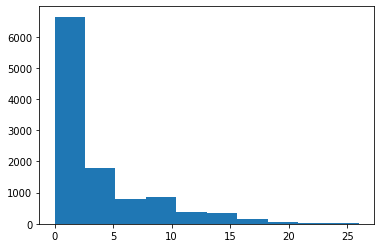

In [87]:
plt.hist(tweets["hashtags_count"])
plt.show()

In [88]:
tweets["hashtags_count"].describe()

count    11075.000000
mean         3.243160
std          4.429164
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max         26.000000
Name: hashtags_count, dtype: float64

What are the most common hashtags?

In [94]:
all_hashtags = []

In [95]:
for lst in tweets["hashtags"]:
    try:
        if len(lst) > 0:
            for elem in lst:
                all_hashtags.append(elem)
    except Exception as e:
        continue

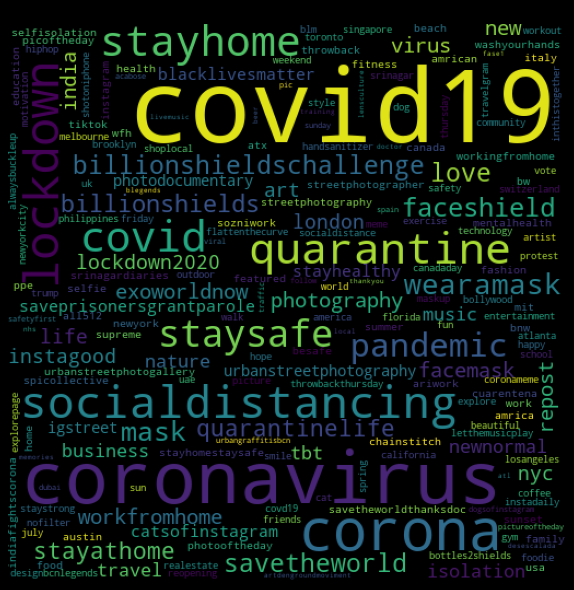

In [108]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(all_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

How does the distribution of hashtags vary across time?

We can look at tweets, by month, and see how the wordcloud changes

In [105]:
april_hashtags = []
may_hashtags = []
june_hashtags = []
july_hashtags = []
september_hashtags = []
october_hashtags = []

In [106]:
for month_num in [4, 5, 6, 7, 9, 10]:
    hashtag_subset = tweets[tweets["month_of_tweet"]==month_num]["hashtags"]
    hashtag_lst = []
    for lst in hashtag_subset:
        try:
            if len(lst) > 0:
                for elem in lst:
                    hashtag_lst.append(elem)
        except Exception as e:
            continue
            
    if month_num == 4:
        april_hashtags = hashtag_lst
    elif month_num == 5:
        may_hashtags = hashtag_lst
    elif month_num == 6:
        june_hashtags = hashtag_lst
    elif month_num == 7:
        july_hashtags = hashtag_lst
    elif month_num == 9:
        september_hashtags = hashtag_lst
    elif month_num == 10:
        october_hashtags = hashtag_lst

Now, let's do the hashtags per month:

#### April

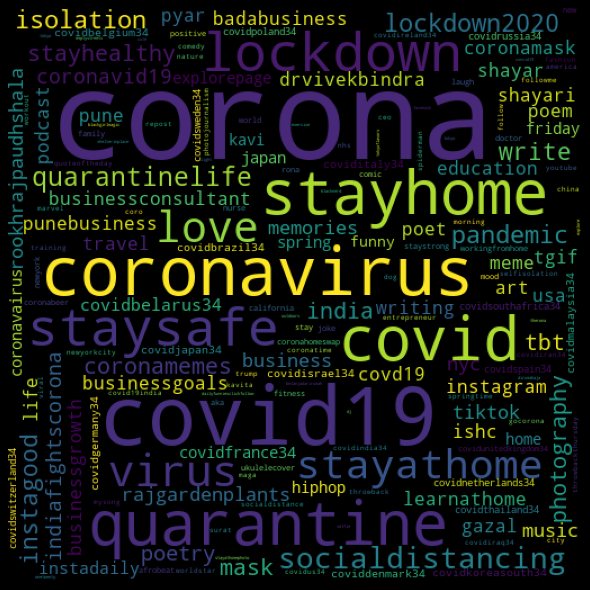

In [109]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(april_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### May

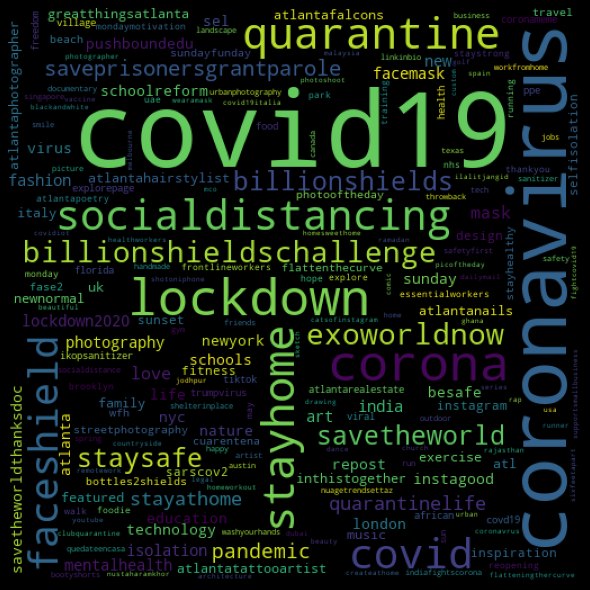

In [110]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(may_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### June

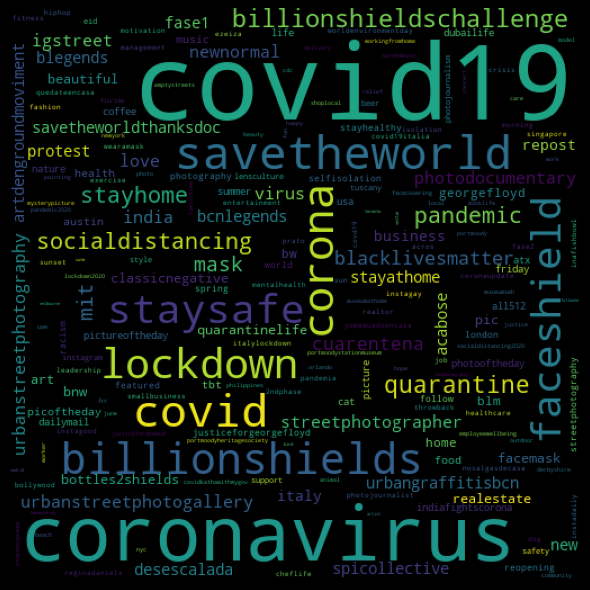

In [111]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(june_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### July

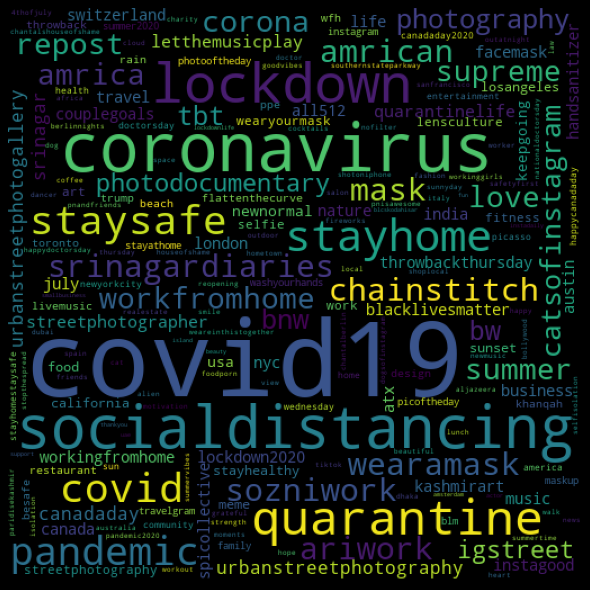

In [112]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(july_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### September

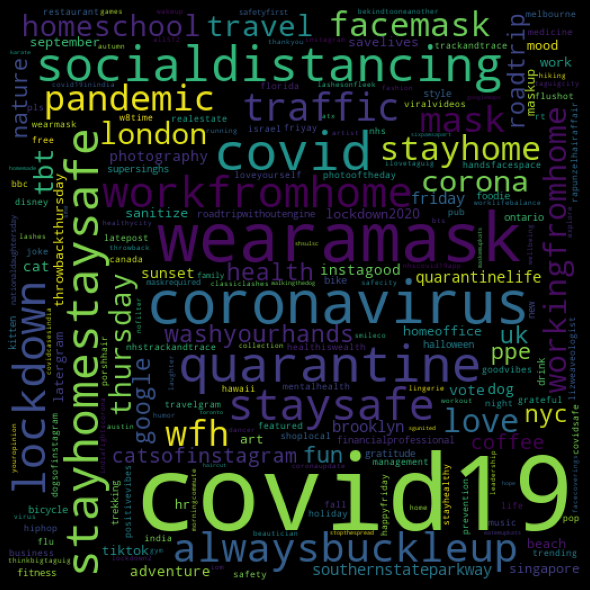

In [113]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(september_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### October

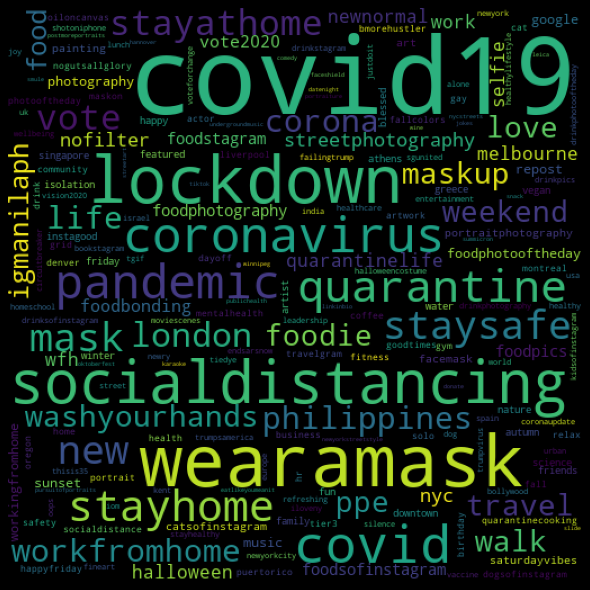

In [114]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(october_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Now, can we evaluate hashtags by location? We have 4 states that have a decent number of tweets ("NY", "CA", "TX", "FL"). Do the hashtags vary in these locations?

In [117]:
NY_hashtags = []
CA_hashtags = []
TX_hashtags = []
FL_hashtags = []


In [118]:
tweets.head()

Unnamed: 0                   id  \
0          0  1250641596887990272   
1          1  1250646705516707840   
2          2  1250647034253709315   
3          3  1250655078744240134   
4          4  1250655491904147456   

                                           full_text retweet_count  \
0  Finally got to a color I love and a length I’m...             0   
1  #wutang #wutangforever #corona @ Downtown Los ...             0   
2  Swirling again @ Corona, California https://t....             0   
3  Does it feel like you want to #Crawl on the wa...             0   
4  Get your stanky booty to Cave Creek &amp; Care...             0   

   favorite_count                                              place US_state  \
0             0.0  {'id': '495a55057ac886b9', 'url': 'https://api...       VT   
1             0.0  {'id': '3b77caf94bfc81fe', 'url': 'https://api...       CA   
2             0.0  {'id': '5e4b6834e36e68fa', 'url': 'https://api...       CA   
3             0.0  {'id': 'd56c5babcffde8ef', 'url': 'https://api...      NaN   
4             1.0  {'id': '005e9bd60c4f1337', 'url': 'https://api...       AZ   

  date_of_tweet  month_of_tweet day_of_tweet hour_of_tweet  \
0    2020-04-16             4.0           16             4   
1    2020-04-16             4.0           16             4   
2    2020-04-16             4.0           16             4   
3    2020-04-16             4.0           16             5   
4    2020-04-16             4.0           16             5   

                                        cleaned_text  \
0  [finally, got, color, love, length, im, okay, ...   
1  [#wutang, #wutangforever, #corona, downtown, l...   
2                     [swirling, corona, california]   
3  [feel, like, want, #crawl, walls, get, heres, ...   
4  [get, stanky, booty, cave, creek, amp, carefre...   

                                            hashtags  hashtags_count  \
0  [#quarantine, #covid, #corona, #haircolor, #ha...            11.0   
1                 [#wutang, #wutangforever, #corona]             3.0   
2                                                 []             0.0   
3  [#crawl, #quarantine, #staygolden, #staysafe, ...             9.0   
4  [#walmart, #cavecreek, #toiletpaper, #quaranti...             6.0   

                            cleaned_text_no_hashtags  
0  [finally, got, color, love, length, im, okay, ...  
1                           [downtown, los, angeles]  
2                     [swirling, corona, california]  
3  [feel, like, want, walls, get, heres, dont, dr...  
4  [get, stanky, booty, cave, creek, amp, carefre...

In [119]:
for state in ["NY", "CA", "TX", "FL"]:
    hashtag_subset = tweets[tweets["US_state"]==state]["hashtags"]
    hashtag_lst = []
    for lst in hashtag_subset:
        try:
            if len(lst) > 0:
                for elem in lst:
                    hashtag_lst.append(elem)
        except Exception as e:
            continue
            
    if state == "NY":
        NY_hashtags = hashtag_lst
    elif state == "CA":
        CA_hashtags = hashtag_lst
    elif state == "TX":
        TX_hashtags = hashtag_lst
    elif state == "FL":
        FL_hashtags = hashtag_lst

#### NY

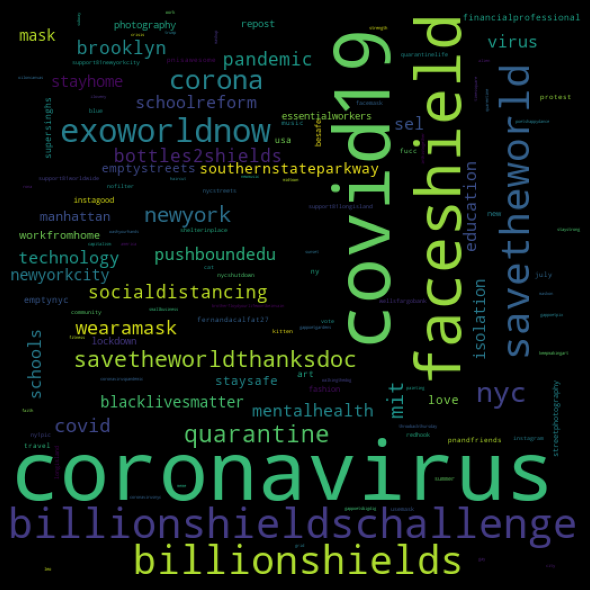

In [120]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(NY_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### CA

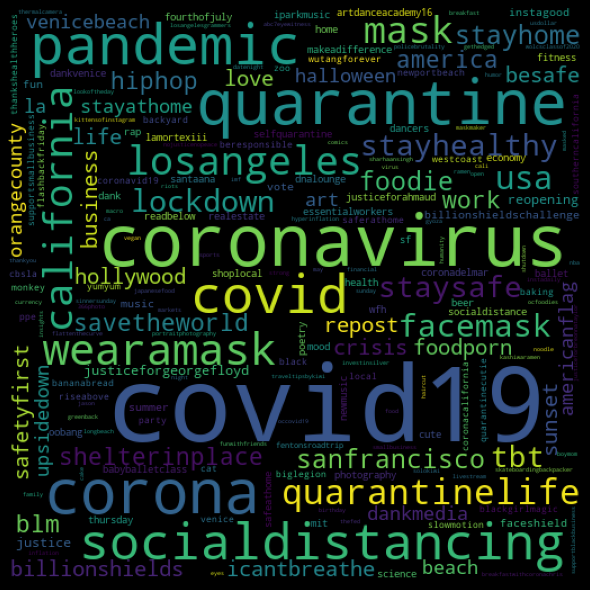

In [121]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(CA_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### TX

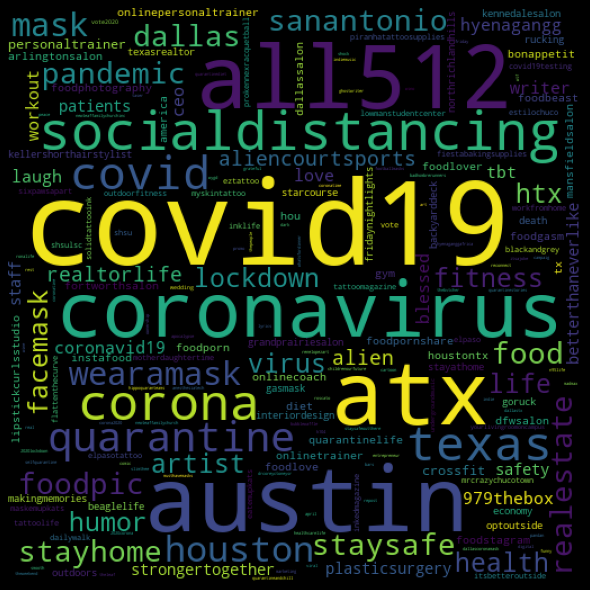

In [122]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(TX_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### FL

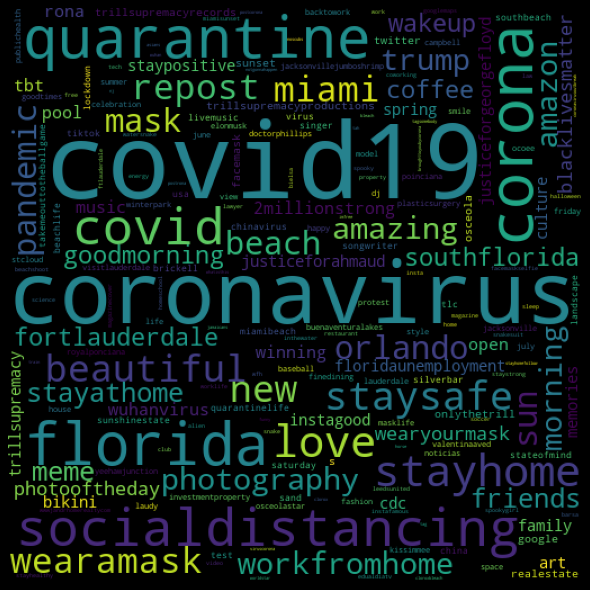

In [123]:
hashtags_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="viridis").generate(" ".join(FL_hashtags))
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hashtags_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### What topics are present in our dataset?

Let's use LDA to get the topics that we see in our dataset

In [125]:
tweets.head()

Unnamed: 0                   id  \
0          0  1250641596887990272   
1          1  1250646705516707840   
2          2  1250647034253709315   
3          3  1250655078744240134   
4          4  1250655491904147456   

                                           full_text retweet_count  \
0  Finally got to a color I love and a length I’m...             0   
1  #wutang #wutangforever #corona @ Downtown Los ...             0   
2  Swirling again @ Corona, California https://t....             0   
3  Does it feel like you want to #Crawl on the wa...             0   
4  Get your stanky booty to Cave Creek &amp; Care...             0   

   favorite_count                                              place US_state  \
0             0.0  {'id': '495a55057ac886b9', 'url': 'https://api...       VT   
1             0.0  {'id': '3b77caf94bfc81fe', 'url': 'https://api...       CA   
2             0.0  {'id': '5e4b6834e36e68fa', 'url': 'https://api...       CA   
3             0.0  {'id': 'd56c5babcffde8ef', 'url': 'https://api...      NaN   
4             1.0  {'id': '005e9bd60c4f1337', 'url': 'https://api...       AZ   

  date_of_tweet  month_of_tweet day_of_tweet hour_of_tweet  \
0    2020-04-16             4.0           16             4   
1    2020-04-16             4.0           16             4   
2    2020-04-16             4.0           16             4   
3    2020-04-16             4.0           16             5   
4    2020-04-16             4.0           16             5   

                                        cleaned_text  \
0  [finally, got, color, love, length, im, okay, ...   
1  [#wutang, #wutangforever, #corona, downtown, l...   
2                     [swirling, corona, california]   
3  [feel, like, want, #crawl, walls, get, heres, ...   
4  [get, stanky, booty, cave, creek, amp, carefre...   

                                            hashtags  hashtags_count  \
0  [#quarantine, #covid, #corona, #haircolor, #ha...            11.0   
1                 [#wutang, #wutangforever, #corona]             3.0   
2                                                 []             0.0   
3  [#crawl, #quarantine, #staygolden, #staysafe, ...             9.0   
4  [#walmart, #cavecreek, #toiletpaper, #quaranti...             6.0   

                            cleaned_text_no_hashtags  
0  [finally, got, color, love, length, im, okay, ...  
1                           [downtown, los, angeles]  
2                     [swirling, corona, california]  
3  [feel, like, want, walls, get, heres, dont, dr...  
4  [get, stanky, booty, cave, creek, amp, carefre...

In [127]:
# create dictionary, corpus for mental health tweets
dict_covid = corpora.Dictionary(tweets["cleaned_text"])
corpus_covid = [dict_covid.doc2bow(tweet) for tweet in tweets["cleaned_text"]]


In [ ]:
# dump corpus as pickle
#pickle.dump(corpus_mental, open('corpus_mental.pkl', 'wb'))
#dictionary_mental.save('dictionary_mental.gensim')

In [128]:
# do LDA (try 10 topics)
NUM_TOPICS = 10
ldamodel_covid = gensim.models.ldamodel.LdaModel(corpus_covid,
                                                 num_topics = NUM_TOPICS, 
                                                 id2word=dict_covid, 
                                                 passes=15)
#ldamodel_covid.save('lda_model_covid_2020-12-18.gensim')
#topics = ldamodel_covid.print_topics(num_words=4)
#for topic in topics:
#    print(topic)

In [129]:
topics = ldamodel_covid.print_topics(num_words=10)
for topic in topics:
    pprint(topic)

(0,
 '0.028*"covid19" + 0.013*"coronavirus" + 0.012*"pandemic" + 0.012*"covid" + '
 '0.011*"lockdown" + 0.010*"new" + 0.009*"stigma" + 0.009*"health" + '
 '0.008*"fighting" + 0.006*"ireland"')
(1,
 '0.050*"social" + 0.042*"distancing" + 0.011*"hand" + 0.006*"#covid19" + '
 '0.005*"impact" + 0.005*"sanitizer" + 0.004*"island" + 0.004*"control" + '
 '0.004*"data" + 0.004*"drinking"')
(2,
 '0.047*"#covid19" + 0.023*"new" + 0.018*"york" + 0.015*"#coronavirus" + '
 '0.013*"#stayhome" + 0.013*"#lockdown" + 0.012*"#staysafe" + '
 '0.011*"#quarantine" + 0.011*"#corona" + 0.010*"#socialdistancing"')
(3,
 '0.008*"miss" + 0.007*"canada" + 0.006*"restaurant" + 0.006*"coffee" + '
 '0.005*"super" + 0.005*"#masks" + 0.005*"#workfromhome" + '
 '0.004*"pennsylvania" + 0.004*"americans" + 0.004*"#bnw"')
(4,
 '0.019*"face" + 0.018*"challenge" + 0.017*"#coronavirus" + 0.014*"become" + '
 '0.011*"empty" + 0.010*"shields" + 0.010*"#faceshield" + 0.010*"hero" + '
 '0.010*"bottles" + 0.009*"soda"')
(5,
 '0.01

In [131]:
lda_display = pyLDAvis.gensim.prepare(ldamodel_covid, 
                                      corpus_covid, 
                                      dict_covid, sort_topics=False)
pyLDAvis.display(lda_display)

Let's look at how accurate our LDA is, using model perplexity and topic coherence

See this tutorial: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [137]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel_covid.log_perplexity(corpus_covid))  # a measure of how good the model is. lower the better.


Perplexity:  -10.501842075403777


In [138]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel_covid, texts=tweets["cleaned_text"], dictionary=dict_covid, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4139339200808373


Now, each document/tweet is a collection of topics, but can we figure out the predominant topic for a given tweet?

In [143]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [144]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel_covid, corpus=corpus_covid, texts=tweets["cleaned_text"])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.7050   
1            1             7.0              0.5219   
2            2             7.0              0.7008   
3            3             2.0              0.4878   
4            4             6.0              0.6897   
5            5             2.0              0.4352   
6            6             0.0              0.5842   
7            7             3.0              0.9500   
8            8             0.0              0.8732   
9            9             9.0              0.3699   

                                            Keywords  \
0  covid19, coronavirus, pandemic, covid, lockdow...   
1  corona, covid, california, amp, home, #covid19...   
2  corona, covid, california, amp, home, #covid19...   
3  #covid19, new, york, #coronavirus, #stayhome, ...   
4  #covid19, #coronavirus, park, #socialdistancin...   
5  #covid19, new, york, #coronavirus, #stayhome, ...   
6  covid19, coronavirus, pandemic, covid, lockdow...   
7  miss, canada, restaurant, coffee, super, #mask...   
8  covid19, coronavirus, pandemic, covid, lockdow...   
9  #covid19, #, covid, georgia, new, bio, atlanta...   

                                                Text  
0  [finally, got, color, love, length, im, okay, ...  
1  [#wutang, #wutangforever, #corona, downtown, l...  
2                     [swirling, corona, california]  
3  [feel, like, want, #crawl, walls, get, heres, ...  
4  [get, stanky, booty, cave, creek, amp, carefre...  
5  [stay, strong, creative, #lockdown, #quarantin...  
6  [#goodmorning, hard, #workers, regardless, #co...  
7  [follow, teamvivekbindra, business, growth, #b...  
8  [anything, us, spending, military, next, eight...  
9  [family, run, homeschooling, pe, real, agenda,...

Now, for each tweet, we have an assigned topic. Let's add these as our "labels"

In [145]:
tweets["dominant_topic_label"] = df_dominant_topic["Dominant_Topic"]
tweets["dominant_topic_keywords"] = df_dominant_topic["Keywords"]

In [146]:
tweets.head()

Unnamed: 0                   id  \
0          0  1250641596887990272   
1          1  1250646705516707840   
2          2  1250647034253709315   
3          3  1250655078744240134   
4          4  1250655491904147456   

                                           full_text retweet_count  \
0  Finally got to a color I love and a length I’m...             0   
1  #wutang #wutangforever #corona @ Downtown Los ...             0   
2  Swirling again @ Corona, California https://t....             0   
3  Does it feel like you want to #Crawl on the wa...             0   
4  Get your stanky booty to Cave Creek &amp; Care...             0   

   favorite_count                                              place US_state  \
0             0.0  {'id': '495a55057ac886b9', 'url': 'https://api...       VT   
1             0.0  {'id': '3b77caf94bfc81fe', 'url': 'https://api...       CA   
2             0.0  {'id': '5e4b6834e36e68fa', 'url': 'https://api...       CA   
3             0.0  {'id': 'd56c5babcffde8ef', 'url': 'https://api...      NaN   
4             1.0  {'id': '005e9bd60c4f1337', 'url': 'https://api...       AZ   

  date_of_tweet  month_of_tweet day_of_tweet hour_of_tweet  \
0    2020-04-16             4.0           16             4   
1    2020-04-16             4.0           16             4   
2    2020-04-16             4.0           16             4   
3    2020-04-16             4.0           16             5   
4    2020-04-16             4.0           16             5   

                                        cleaned_text  \
0  [finally, got, color, love, length, im, okay, ...   
1  [#wutang, #wutangforever, #corona, downtown, l...   
2                     [swirling, corona, california]   
3  [feel, like, want, #crawl, walls, get, heres, ...   
4  [get, stanky, booty, cave, creek, amp, carefre...   

                                            hashtags  hashtags_count  \
0  [#quarantine, #covid, #corona, #haircolor, #ha...            11.0   
1                 [#wutang, #wutangforever, #corona]             3.0   
2                                                 []             0.0   
3  [#crawl, #quarantine, #staygolden, #staysafe, ...             9.0   
4  [#walmart, #cavecreek, #toiletpaper, #quaranti...             6.0   

                            cleaned_text_no_hashtags  dominant_topic_label  \
0  [finally, got, color, love, length, im, okay, ...                   0.0   
1                           [downtown, los, angeles]                   7.0   
2                     [swirling, corona, california]                   7.0   
3  [feel, like, want, walls, get, heres, dont, dr...                   2.0   
4  [get, stanky, booty, cave, creek, amp, carefre...                   6.0   

                             dominant_topic_keywords  
0  covid19, coronavirus, pandemic, covid, lockdow...  
1  corona, covid, california, amp, home, #covid19...  
2  corona, covid, california, amp, home, #covid19...  
3  #covid19, new, york, #coronavirus, #stayhome, ...  
4  #covid19, #coronavirus, park, #socialdistancin...

Is there a difference in topic distribution across months?

In [151]:
pd.crosstab(tweets["month_of_tweet"], tweets["dominant_topic_label"], margins = True, normalize = "index")

dominant_topic_label       0.0       1.0       2.0       3.0       4.0  \
month_of_tweet                                                           
4.0                   0.226817  0.035088  0.114035  0.063910  0.022556   
5.0                   0.471379  0.034960  0.100653  0.015751  0.045332   
6.0                   0.598627  0.016934  0.095195  0.006865  0.043021   
7.0                   0.617137  0.027920  0.096277  0.012837  0.001605   
9.0                   0.528689  0.039344  0.089344  0.011475  0.003279   
10.0                  0.455256  0.039965  0.073849  0.025195  0.005213   
All                   0.524519  0.030434  0.095277  0.017159  0.022126   

dominant_topic_label       5.0       6.0       7.0       8.0       9.0  
month_of_tweet                                                          
4.0                   0.078947  0.050125  0.150376  0.157895  0.100251  
5.0                   0.055705  0.062236  0.128698  0.026124  0.059163  
6.0                   0.027002  0.040275  0.135011  0.005950  0.031121  
7.0                   0.030488  0.025674  0.147625  0.005456  0.034981  
9.0                   0.029508  0.029508  0.212295  0.004098  0.052459  
10.0                  0.039096  0.044309  0.225891  0.015639  0.075586  
All                   0.040007  0.041272  0.156146  0.022307  0.050754

Seems like there is some difference in the distribution of topics across time

Now, let's see if there's a difference in the distribution of topics across locations (limiting our search to "CA", "NY", "TX", and "FL")

In [154]:
tweets.head()

Unnamed: 0                   id  \
0          0  1250641596887990272   
1          1  1250646705516707840   
2          2  1250647034253709315   
3          3  1250655078744240134   
4          4  1250655491904147456   

                                           full_text retweet_count  \
0  Finally got to a color I love and a length I’m...             0   
1  #wutang #wutangforever #corona @ Downtown Los ...             0   
2  Swirling again @ Corona, California https://t....             0   
3  Does it feel like you want to #Crawl on the wa...             0   
4  Get your stanky booty to Cave Creek &amp; Care...             0   

   favorite_count                                              place US_state  \
0             0.0  {'id': '495a55057ac886b9', 'url': 'https://api...       VT   
1             0.0  {'id': '3b77caf94bfc81fe', 'url': 'https://api...       CA   
2             0.0  {'id': '5e4b6834e36e68fa', 'url': 'https://api...       CA   
3             0.0  {'id': 'd56c5babcffde8ef', 'url': 'https://api...      NaN   
4             1.0  {'id': '005e9bd60c4f1337', 'url': 'https://api...       AZ   

  date_of_tweet  month_of_tweet day_of_tweet hour_of_tweet  \
0    2020-04-16             4.0           16             4   
1    2020-04-16             4.0           16             4   
2    2020-04-16             4.0           16             4   
3    2020-04-16             4.0           16             5   
4    2020-04-16             4.0           16             5   

                                        cleaned_text  \
0  [finally, got, color, love, length, im, okay, ...   
1  [#wutang, #wutangforever, #corona, downtown, l...   
2                     [swirling, corona, california]   
3  [feel, like, want, #crawl, walls, get, heres, ...   
4  [get, stanky, booty, cave, creek, amp, carefre...   

                                            hashtags  hashtags_count  \
0  [#quarantine, #covid, #corona, #haircolor, #ha...            11.0   
1                 [#wutang, #wutangforever, #corona]             3.0   
2                                                 []             0.0   
3  [#crawl, #quarantine, #staygolden, #staysafe, ...             9.0   
4  [#walmart, #cavecreek, #toiletpaper, #quaranti...             6.0   

                            cleaned_text_no_hashtags  dominant_topic_label  \
0  [finally, got, color, love, length, im, okay, ...                   0.0   
1                           [downtown, los, angeles]                   7.0   
2                     [swirling, corona, california]                   7.0   
3  [feel, like, want, walls, get, heres, dont, dr...                   2.0   
4  [get, stanky, booty, cave, creek, amp, carefre...                   6.0   

                             dominant_topic_keywords  
0  covid19, coronavirus, pandemic, covid, lockdow...  
1  corona, covid, california, amp, home, #covid19...  
2  corona, covid, california, amp, home, #covid19...  
3  #covid19, new, york, #coronavirus, #stayhome, ...  
4  #covid19, #coronavirus, park, #socialdistancin...

In [153]:
bool_state_arr = []

In [155]:
for state in tweets["US_state"]:
    if state in ["NY", "CA", "FL", "TX"]:
        bool_state_arr.append(True)
    else:
        bool_state_arr.append(False)

In [156]:
tweets_filtered = tweets[bool_state_arr]

In [158]:
pd.crosstab(tweets_filtered["US_state"], tweets_filtered["dominant_topic_label"], margins = True, normalize = "index")

dominant_topic_label       0.0       1.0       2.0       3.0       4.0  \
US_state                                                                 
CA                    0.392405  0.016110  0.055236  0.014960  0.013809   
FL                    0.461290  0.032258  0.112903  0.016129  0.019355   
NY                    0.366817  0.013544  0.170429  0.016930  0.164786   
TX                    0.635220  0.018868  0.059748  0.006289  0.000000   
All                   0.424255  0.017625  0.106169  0.014687  0.068821   

dominant_topic_label       5.0       6.0       7.0       8.0       9.0  
US_state                                                                
CA                    0.020713  0.023015  0.371692  0.008055  0.084005  
FL                    0.035484  0.006452  0.264516  0.003226  0.048387  
NY                    0.036117  0.062077  0.129797  0.010158  0.029345  
TX                    0.015723  0.044025  0.135220  0.006289  0.078616  
All                   0.027696  0.038187  0.236257  0.007973  0.058330

### Sentiment Analysis